In [1]:
%run tools.ipynb

# Model training

In [2]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from torch.utils.data import DataLoader
from pymatgen import Structure

from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipNorm
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.model.training.dataset import ArrayDataset, CrystalGraphDataset
from xenonpy.model.utils import regression_metrics
from xenonpy.model import CrystalGraphConvNet

from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions, CrystalGraphFeaturizer

## sample data

In [79]:
data.sort_values('formation_energy_per_atom', ascending=False)

band_gap                         composition   density  \
mp-1097563    0.4445    {'Ta': 1.0, 'Re': 1.0, 'W': 2.0}  1.564786   
mp-1097618    0.1770    {'Ta': 1.0, 'Mo': 1.0, 'W': 2.0}  1.354216   
mp-1096421    0.0702    {'Ta': 1.0, 'Nb': 1.0, 'W': 2.0}  1.354753   
mp-1097408    0.1239    {'Nb': 1.0, 'Re': 1.0, 'W': 2.0}  1.438029   
mp-1096654    0.0000     {'V': 1.0, 'Re': 1.0, 'W': 2.0}  1.234458   
mp-1214031    0.0000               {'Ca': 2.0, 'C': 8.0}  0.354586   
mp-1097495    0.0000    {'Re': 1.0, 'Mo': 1.0, 'W': 2.0}  1.396952   
mp-1076923    0.0000                         {'Ta': 4.0}  0.970333   
mp-1097678    0.0000    {'Ta': 2.0, 'Mo': 1.0, 'W': 1.0}  1.298420   
mp-1093614    0.0564    {'Ta': 2.0, 'Nb': 1.0, 'W': 1.0}  1.269797   
mp-1097616    0.0000     {'Ta': 1.0, 'V': 1.0, 'W': 2.0}  1.327660   
mp-1096008    0.1177    {'Nb': 1.0, 'Mo': 1.0, 'W': 2.0}  0.892558   
mp-1093584    0.0000    {'Cr': 1.0, 'Re': 1.0, 'W': 2.0}  1.170316   
mp-1097266    0.0000    {'Ta': 1.0, 'Ti': 1.0, 'W': 2.0}  1.074659   
mp-1095987    0.0000    {'Cr': 1.0, 'Mo': 1.0, 'W': 2.0}  1.091137   
mp-1095756    0.0000    {'Ti': 1.0, 'Re': 1.0, 'W': 2.0}  1.285829   
mp-1210637    0.0491    {'Th': 4.0, 'B': 8.0, 'Os': 8.0}  0.705068   
mp-1093743    0.0000     {'Nb': 1.0, 'V': 1.0, 'W': 2.0}  1.132743   
mp-1093977    0.0000    {'Ta': 1.0, 'Nb': 2.0, 'W': 1.0}  1.111874   
mp-1095927    0.0612    {'Ta': 2.0, 'Ti': 1.0, 'W': 1.0}  1.207132   
mp-1097234    0.0000     {'V': 1.0, 'Cr': 1.0, 'W': 2.0}  1.120762   
mp-1093572    0.0000     {'V': 1.0, 'Mo': 1.0, 'W': 2.0}  0.831104   
mp-1096450    0.0666    {'Ta': 1.0, 'Mo': 2.0, 'W': 1.0}  1.144956   
mp-1096054    0.0000    {'Nb': 1.0, 'Re': 2.0, 'W': 1.0}  1.420665   
mp-1096279    0.1003    {'Nb': 1.0, 'Tc': 1.0, 'W': 2.0}  1.203579   
mp-1095944    0.0311    {'Ta': 2.0, 'Cr': 1.0, 'W': 1.0}  1.189183   
mp-1093627    0.3644   {'Ta': 2.0, 'Nb': 1.0, 'Re': 1.0}  1.307553   
mp-1093849    0.1296    {'Nb': 2.0, 'Re': 1.0, 'W': 1.0}  1.181209   
mp-1093600    0.0000    {'Tc': 1.0, 'Mo': 1.0, 'W': 2.0}  1.223680   
mp-1096704    0.0802   {'Ta': 1.0, 'Nb': 1.0, 'Re': 2.0}  1.461838   
...              ...                                 ...       ...   
mp-768240     7.0525     {'Ba': 1.0, 'Y': 2.0, 'F': 8.0}  4.813394   
mp-1191736    7.4315               {'Y': 6.0, 'F': 18.0}  5.080879   
mp-17673      5.6394   {'Lu': 12.0, 'O': 8.0, 'F': 20.0}  8.719300   
mp-1210818    7.7160              {'Lu': 6.0, 'F': 18.0}  8.744272   
mp-862671     6.1267              {'Th': 6.0, 'F': 24.0}  7.043612   
mp-977360     7.3459               {'Ac': 1.0, 'F': 3.0}  8.546579   
mp-2651       7.5968              {'F': 18.0, 'Pr': 6.0}  6.078067   
mp-985278     6.0652               {'Ac': 1.0, 'F': 3.0}  8.522773   
mp-27185      6.4663    {'F': 25.0, 'K': 1.0, 'Th': 6.0}  6.127004   
mp-18511      7.6680              {'F': 18.0, 'Nd': 6.0}  6.337593   
mp-254        7.6164              {'F': 18.0, 'Nd': 6.0}  6.332446   
mp-12803      7.2150    {'F': 8.0, 'Ba': 1.0, 'Er': 2.0}  6.618041   
mp-1214962    7.3108  {'Ba': 8.0, 'Lu': 16.0, 'F': 64.0}  6.828391   
mp-2416       7.5338               {'F': 12.0, 'Y': 4.0}  4.778108   
mp-1212889    7.8626              {'Dy': 6.0, 'F': 18.0}  7.692130   
mp-7693       7.2347    {'F': 8.0, 'Ba': 1.0, 'Tm': 2.0}  6.749394   
mp-675492     6.0367   {'Sr': 1.0, 'La': 5.0, 'F': 17.0}  5.465893   
mp-7384       7.7298              {'F': 12.0, 'Sm': 4.0}  6.510594   
mp-561877     7.7482              {'Ho': 4.0, 'F': 12.0}  7.582609   
mp-865934     6.7345               {'Yb': 2.0, 'F': 4.0}  7.541454   
mp-11347      7.7511              {'F': 12.0, 'Tb': 4.0}  7.163536   
mp-8354       5.7610               {'F': 6.0, 'La': 2.0}  5.792261   
mp-9371       7.6163              {'F': 12.0, 'Er': 4.0}  7.477903   
mp-334        6.0452              {'F': 18.0, 'La': 6.0}  5.810267   
mp-905        6.0429              {'F': 18.0, 'La': 6.0}  5.807029   
mp-31034      6.5408  

In [31]:
data = preset.mp_inorganic
data.head(5)

band_gap                        composition    density  \
mp-10018      0.0000                        {'Ac': 1.0}   8.305509   
mp-1006278    0.0000  {'Eu': 1.0, 'Ac': 1.0, 'Au': 2.0}  10.961905   
mp-1008601    0.0013             {'Zr': 1.0, 'Ag': 2.0}   8.768805   
mp-1008617    0.0000             {'Yb': 1.0, 'Ag': 2.0}   9.884232   
mp-1008653    0.0000              {'Ag': 1.0, 'C': 1.0}   7.829365   

            e_above_hull    efermi      elements  final_energy_per_atom  \
mp-10018        0.033002  6.049081          [Ac]              -4.094619   
mp-1006278      0.000000  4.841036  [Ac, Au, Eu]              -6.014166   
mp-1008601      0.034454  4.163828      [Zr, Ag]              -4.784354   
mp-1008617      0.031899  2.658758      [Yb, Ag]              -2.735972   
mp-1008653      2.235059  4.001158       [Ag, C]              -3.793546   

            formation_energy_per_atom  has_bandstructure  is_hubbard  \
mp-10018                     0.033002               True       False   
mp-1006278                  -0.772196               True       False   
mp-1008601                  -0.047356               True       False   
mp-1008617                  -0.338535               True       False   
mp-1008653                   2.235059               True       False   

            is_ordered  n_elemets  nsites oxide_type point_group  \
mp-10018          True          1       1       None        m-3m   
mp-1006278        True          3       4       None        m-3m   
mp-1008601        True          2       3       None       4/mmm   
mp-1008617        True          2       3       None       4/mmm   
mp-1008653        True          2       2       None        m-3m   

           pretty_formula space_group  space_group_number  \
mp-10018               Ac       Fm-3m                 225   
mp-1006278        AcEuAu2       Fm-3m                 225   
mp-1008601          ZrAg2      I4/mmm                 139   
mp-1008617          YbAg2      I4/mmm                 139   
mp-1008653            AgC       Fm-3m                 225   

            total_magnetization      volume  
mp-10018               0.000148   45.384620  
mp-1006278             7.195618  117.080546  
mp-1008601             0.000002   58.128759  
mp-1008617             0.000686   65.313964  
mp-1008653             0.000031   25.425252

## compositional descriptor

In [32]:
desc = Compositions(featurizers='classic').transform(data['composition'])
prop = data['volume'].to_frame()

desc.head(5)
prop.head(5)

ave:atomic_number  ave:atomic_radius  ave:atomic_radius_rahm  \
mp-10018            89.000000         188.000000              293.000000   
mp-1006278          77.500000         169.750000              256.250000   
mp-1008601          44.666667         149.333333              239.333333   
mp-1008617          54.666667         160.666667              242.333333   
mp-1008653          26.500000         117.500000              207.500000   

            ave:atomic_volume  ave:atomic_weight  ave:boiling_point  \
mp-10018            22.540000         227.000000        3470.000000   
mp-1006278          17.960000         193.224285        2875.000000   
mp-1008601          11.566667         102.320133        3206.666667   
mp-1008617          15.133333         129.593800        2145.333333   
mp-1008653           7.800000          59.939600        3792.500000   

            ave:bulk_modulus    ave:c6_gb  ave:covalent_radius_cordero  \
mp-10018          109.799299  2178.590739                       215.00   
mp-1006278        139.524825  1493.147685                       171.25   
mp-1008601        124.173273   680.666667                       155.00   
mp-1008617         77.000000   864.000000                       159.00   
mp-1008653         66.500000   194.450000                       109.00   

            ave:covalent_radius_pyykko  ...  min:num_s_valence  min:period  \
mp-10018                    186.000000  ...                2.0         7.0   
mp-1006278                  150.500000  ...                1.0         6.0   
mp-1008601                  136.666667  ...                1.0         5.0   
mp-1008617                  142.000000  ...                1.0         5.0   
mp-1008653                  101.500000  ...                1.0         2.0   

            min:specific_heat  min:thermal_conductivity  min:vdw_radius  \
mp-10018             0.716726                      12.0           247.0   
mp-1006278           0.129000                      12.0           214.0   
mp-1008601           0.237000                      23.0           211.0   
mp-1008617           0.145000                      39.0           211.0   
mp-1008653           0.237000                     140.0           170.0   

            min:vdw_radius_alvarez  min:vdw_radius_mm3  min:vdw_radius_uff  \
mp-10018                     280.0               308.0               347.8   
mp-1006278                   232.0               243.0               329.3   
mp-1008601                   252.0               243.0               312.4   
mp-1008617                   253.0               243.0               314.8   
mp-1008653                   177.0               204.0               314.8   

            min:sound_velocity  min:Polarizability  
mp-10018           3633.642953               32.10  
mp-1006278         1740.000000                5.80  
mp-1008601         2600.000000                6.78  
mp-1008617         1590.000000                6.78  
mp-1008653         2600.000000                1.67  

[5 rows x 290 columns]

volume
mp-10018     45.384620
mp-1006278  117.080546
mp-1008601   58.128759
mp-1008617   65.313964
mp-1008653   25.425252

In [33]:
sp = Splitter(prop.shape[0])
x_train, x_val, y_train, y_val = sp.split(desc, prop)

In [34]:
x_train.shape
y_train.shape
x_val.shape
y_val.shape

(96489, 290)

(96489, 1)

(24123, 290)

(24123, 1)

In [64]:
model = torch.nn.Sequential(
    torch.nn.Linear(290, 200),
    torch.nn.BatchNorm1d(200),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(200, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(100, 50),
    torch.nn.BatchNorm1d(50),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(50, 1),
)
model

Sequential(
  (0): Linear(in_features=290, out_features=200, bias=True)
  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.1)
  (8): Linear(in_features=100, out_features=50, bias=True)
  (9): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.1)
  (12): Linear(in_features=50, out_features=1, bias=True)
)

In [65]:
trainer = Trainer(
    model=model,
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
#     clip_grad=ClipNorm(max_norm=0.5)
)

In [66]:
trainer.extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=25, trace_order=1, mae=0.0, pearsonr=1.0),
)

In [67]:
train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=1000)
val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=1000)

In [68]:
trainer.fit(x_train, y_train, x_val=x_val, y_val=y_val, epochs=600)

Training:  72%|███████▏  | 430/600 [06:58<02:57,  1.04s/it]/Users/liuchang/projects/xenonpy/xenonpy/model/training/trainer.py:406: UserWarning:

early stopping is applied: no improvement for ['mae', 'pearsonr'] in the last 26 iterations, finish training at iterations 430




In [69]:
trainer.step_info.head(5)

total_iters  i_epoch  i_batch   train_loss     val_mae      val_mse  \
0            1        1        1  575665.0000  500.333374  578140.6250   
1            2        2        1  575472.8125  500.254120  578055.0000   
2            3        3        1  575289.1250  500.170959  577961.0625   
3            4        4        1  575111.1250  500.112671  577885.5625   
4            5        5        1  574932.3750  500.007721  577738.5000   

     val_rmse        val_r2  val_pearsonr  val_spearmanr    val_p_value  \
0  760.355591 -8.474657e+06      0.104198       0.164263   3.256341e-59   
1  760.299255 -7.681175e+06      0.119501       0.148482   1.967853e-77   
2  760.237488 -7.441818e+06      0.151279       0.144961  1.857277e-123   
3  760.187866 -5.987309e+06      0.184064       0.152029  8.212341e-183   
4  760.091125 -2.117800e+06      0.180124       0.174148  4.987513e-175   

   val_max_error  
0   20090.712891  
1   20090.589844  
2   20090.427734  
3   20090.322266  
4   20090.292969

In [70]:
trainer.get_checkpoint()
trainer.get_checkpoint('pearsonr')['total_iteration']
trainer.get_checkpoint('mae')['total_iteration']

['mae', 'pearsonr']

405

397

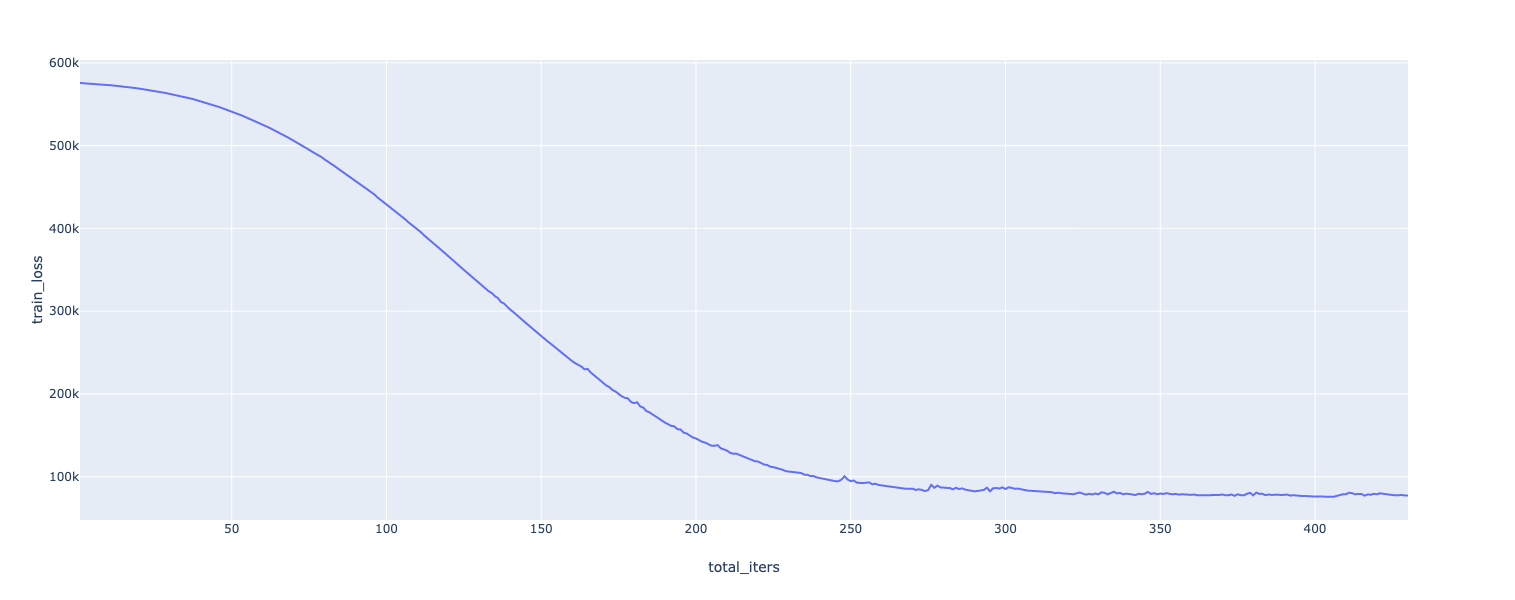

In [71]:
fig = px.line(trainer.step_info, x='total_iters', y='train_loss')
fig.show()


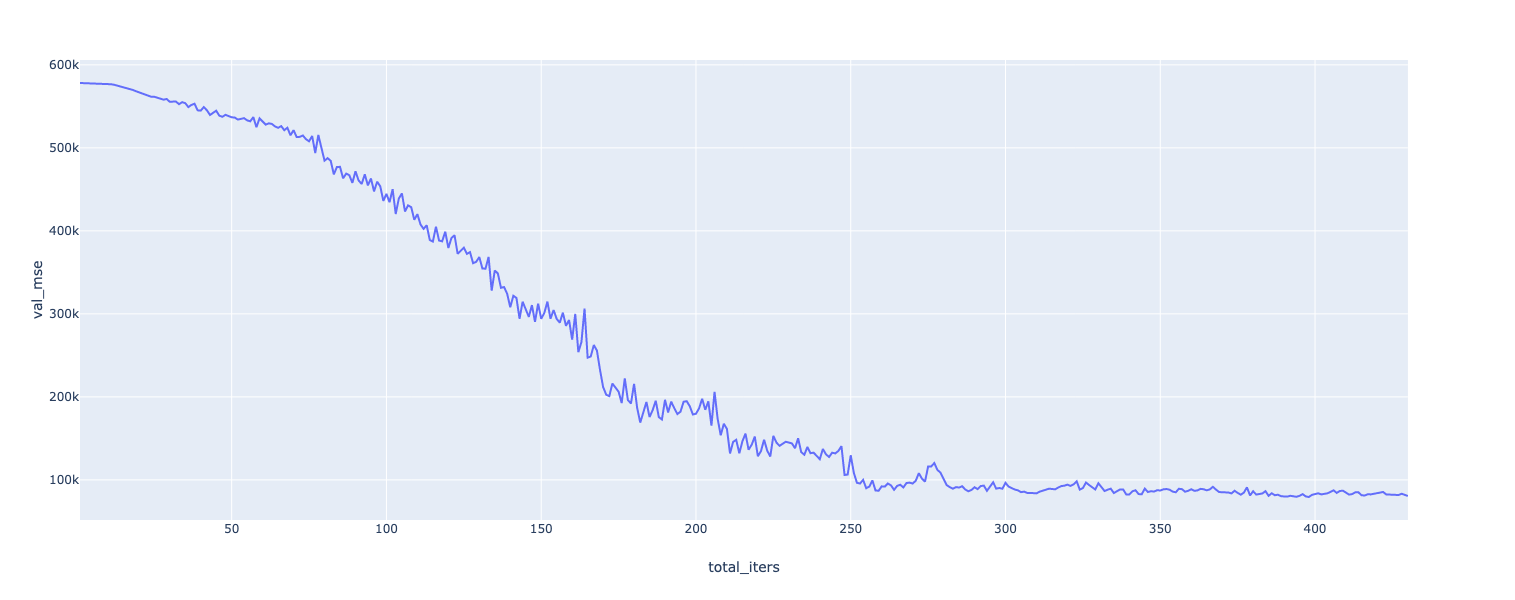

In [72]:
fig = px.line(trainer.step_info, x='total_iters', y='val_mse')
fig.show()


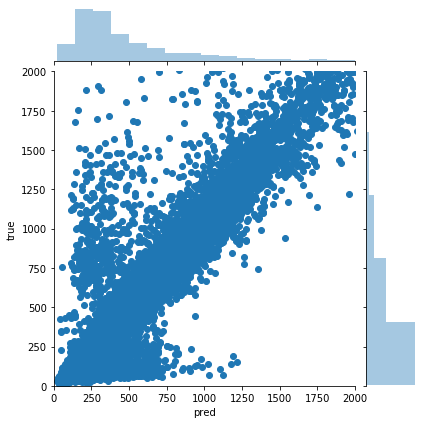

In [73]:
y_pred = trainer.predict(x_val)

# _, ax = plt.subplots(figsize=(10, 10), dpi=100)

ax = sns.jointplot(data=pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true', xlim=(0, 2000), ylim=(0, 2000))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)

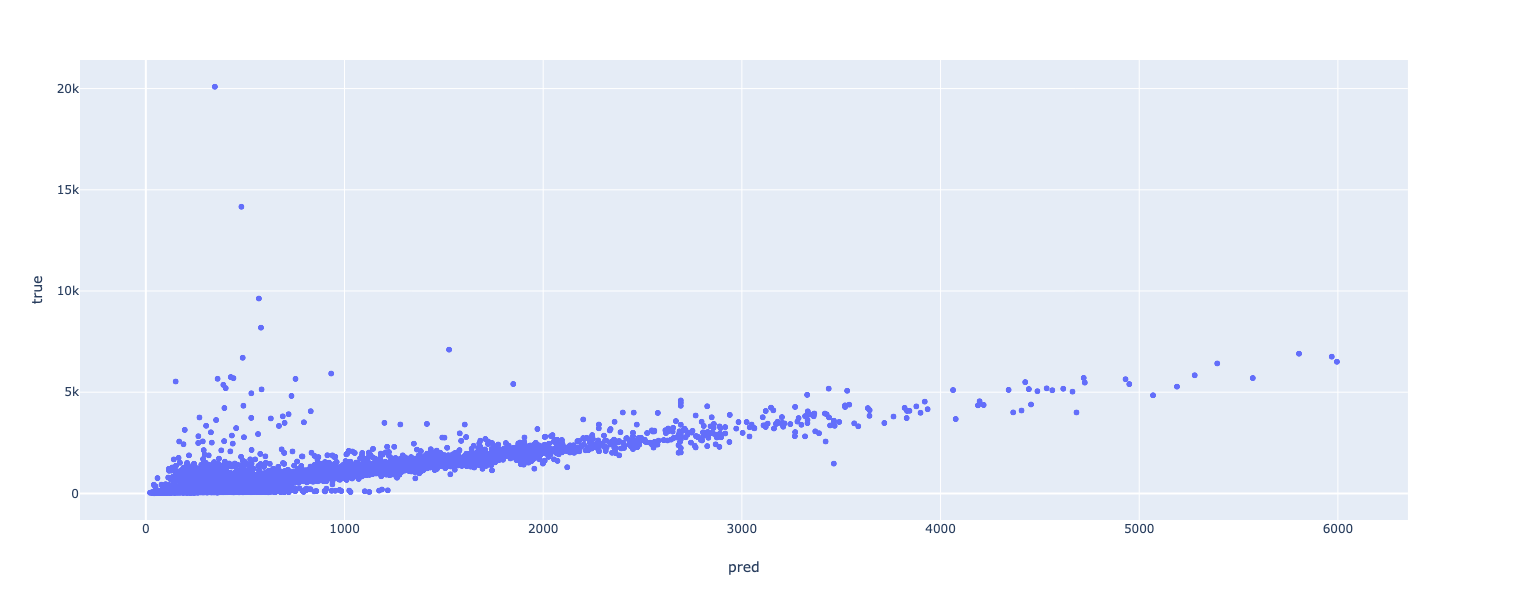

In [74]:
y_pred = trainer.predict(x_val)
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true')
fig.show()

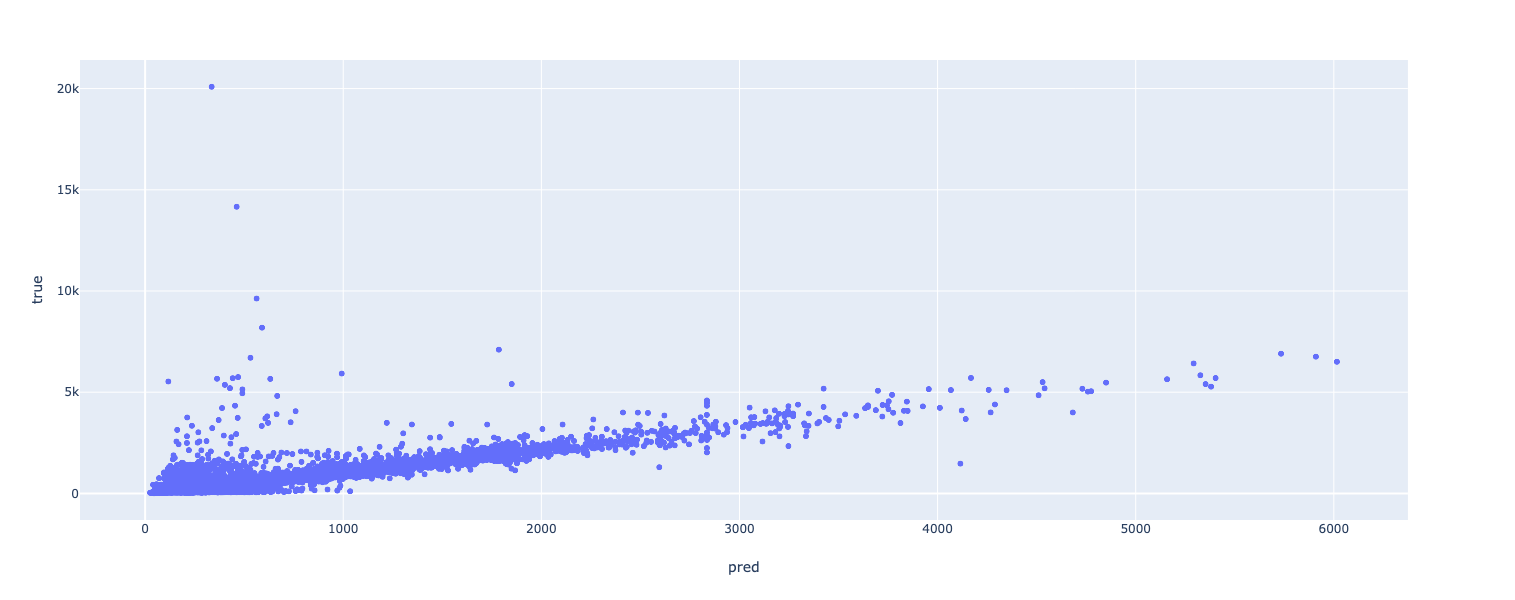

In [75]:
y_pred = trainer.predict(x_val, check_point='mae')
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true')
fig.show()

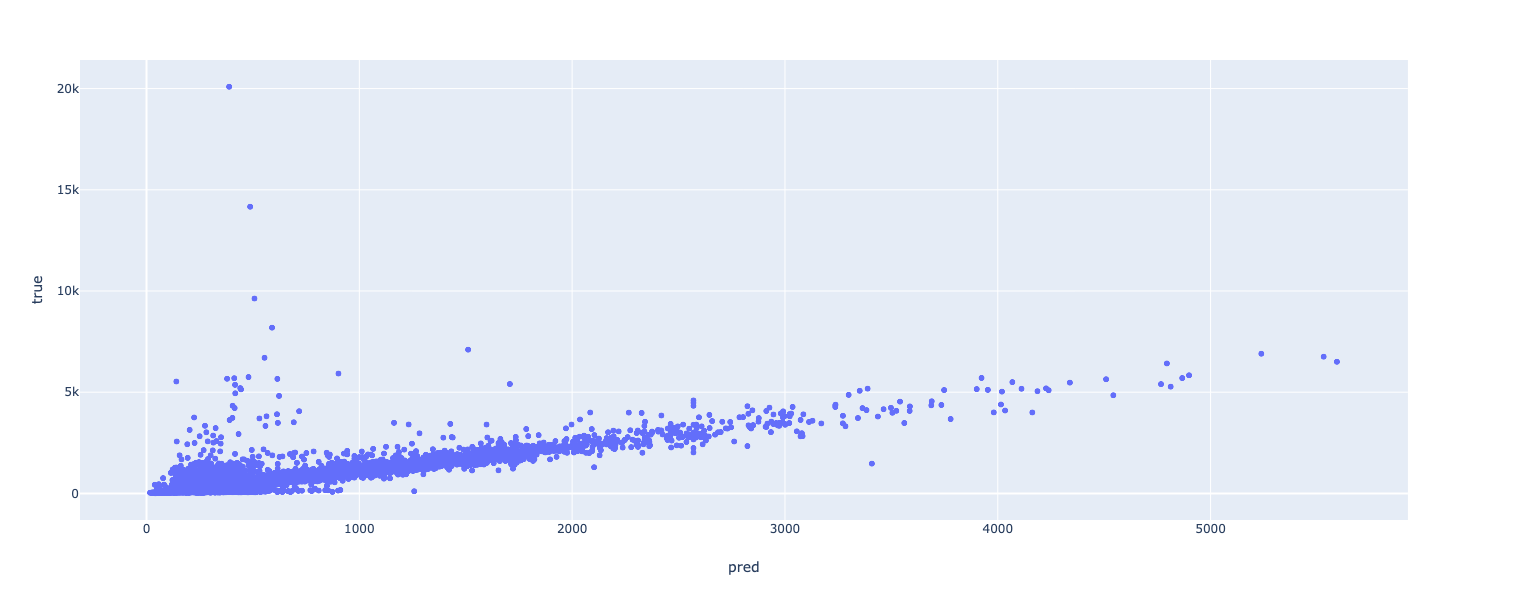

In [76]:
y_pred = trainer.predict(x_val, check_point='pearsonr')
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true')
fig.show()

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [83]:
rf.fit(x_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

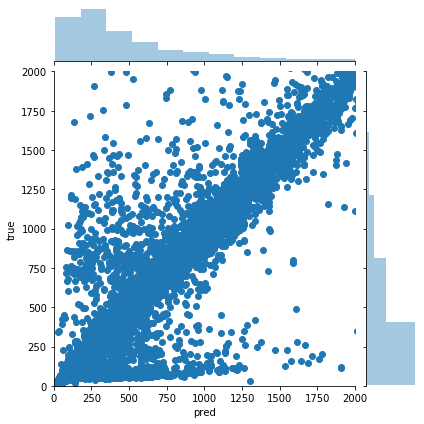

In [84]:
y_pred = rf.predict(x_val)

# _, ax = plt.subplots(figsize=(10, 10), dpi=100)

ax = sns.jointplot(data=pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true', xlim=(0, 2000), ylim=(0, 2000))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)

## crystal graph cnn

In [25]:
desc = CrystalGraphFeaturizer().transform(data['structure'])
prop = data['volume'].to_frame()

desc.head(5)
prop.head(5)

atom_feature  \
mp-1008807  [[tensor(0.), tensor(1.), tensor(0.), tensor(0...   
mp-1009640  [[tensor(1.), tensor(0.), tensor(0.), tensor(0...   
mp-1016825  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   
mp-1017582  [[tensor(1.), tensor(0.), tensor(0.), tensor(0...   
mp-1021511  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   

                                             neighbor_feature  \
mp-1008807  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1009640  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1016825  [[[tensor(1.4013e-45), tensor(2.4653e-37), ten...   
mp-1017582  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1021511  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   

                                                 neighbor_idx  
mp-1008807  [[tensor(2), tensor(2), tensor(2), tensor(2), ...  
mp-1009640  [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
mp-1016825  [[tensor(2), tensor(3), tensor(4), tensor(2), ...  
mp-1017582  [[tensor(1), tensor(2), tensor(3), tensor(1), ...  
mp-1021511  [[tensor(1), tensor(1), tensor(1), tensor(0), ...

volume
mp-1008807  57.268924
mp-1009640  31.579717
mp-1016825  67.541269
mp-1017582  85.579224
mp-1021511  92.890725

In [26]:
sp = Splitter(prop.shape[0])
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [27]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(743, 3)

(743, 1)

(186, 3)

(186, 1)

In [30]:
train_dataloader = DataLoader(CrystalGraphDataset(x_train, y_train), shuffle=True,
                              batch_size=20, collate_fn=CrystalGraphDataset.collate_fn)
val_dataloader = DataLoader(CrystalGraphDataset(x_test, y_test),
                              batch_size=20, collate_fn=CrystalGraphDataset.collate_fn)

In [31]:
cgcnn = CrystalGraphConvNet(orig_atom_fea_len=92, nbr_fea_len=41, atom_fea_len=128, h_fea_len=64, n_conv=1, n_h=1)
cgcnn

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=128, bias=True)
  (convs): ModuleList(
    (0): ConvLayer(
      (fc_full): Linear(in_features=297, out_features=256, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=128, out_features=64, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
trainer = Trainer(
    model=cgcnn,
    optimizer=Adam(lr=0.0005),
    loss_func=MSELoss(),
    lr_scheduler=ExponentialLR(gamma=0.99),
    clip_grad=ClipNorm(max_norm=0.04)
)

In [34]:
trainer.extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=30, pearsonr=1.0, mse=0.0, r2=0.0, mae=0.0),
)

In [35]:
trainer.fit(training_dataset=train_dataloader, validation_dataset=val_dataloader, epochs=100)

Training:  10%|█         | 10/100 [04:20<40:49, 27.22s/it]


KeyboardInterrupt: 

In [36]:
trainer.step_info.head(5)

total_iters  i_epoch  i_batch    train_loss     val_mae       val_mse  \
0            1        1        1  467276.53125  451.089722  389803.68750   
1            2        1        2  395540.56250  450.737061  389485.81250   
2            3        1        3  358877.56250  450.379120  389163.09375   
3            4        1        4  345053.00000  450.017853  388837.56250   
4            5        1        5  676405.62500  449.654388  388510.18750   

     val_rmse        val_r2  val_pearsonr  val_spearmanr  val_p_value  \
0  624.342590 -1.307828e+09     -0.068207      -0.073312     0.354952   
1  624.088013 -1.372908e+09     -0.080259      -0.094169     0.276170   
2  623.829407 -1.597879e+09     -0.075096      -0.076738     0.308342   
3  623.568420 -1.864701e+09     -0.063920      -0.041640     0.386073   
4  623.305847 -2.005415e+09     -0.038235       0.009120     0.604367   

   val_max_error  
0    3171.239746  
1    3170.884521  
2    3170.525146  
3    3170.162842  
4    3169.798340

In [42]:
trainer._check_points.keys()
trainer._check_points['pearsonr']['total_iteration']
trainer._check_points['mae']['total_iteration']
trainer._check_points['mse']['total_iteration']

dict_keys(['pearsonr', 'mse', 'r2', 'mae'])

365

343

360

In [37]:
trainer._check_points.keys()

dict_keys(['pearsonr', 'mse', 'r2', 'mae'])

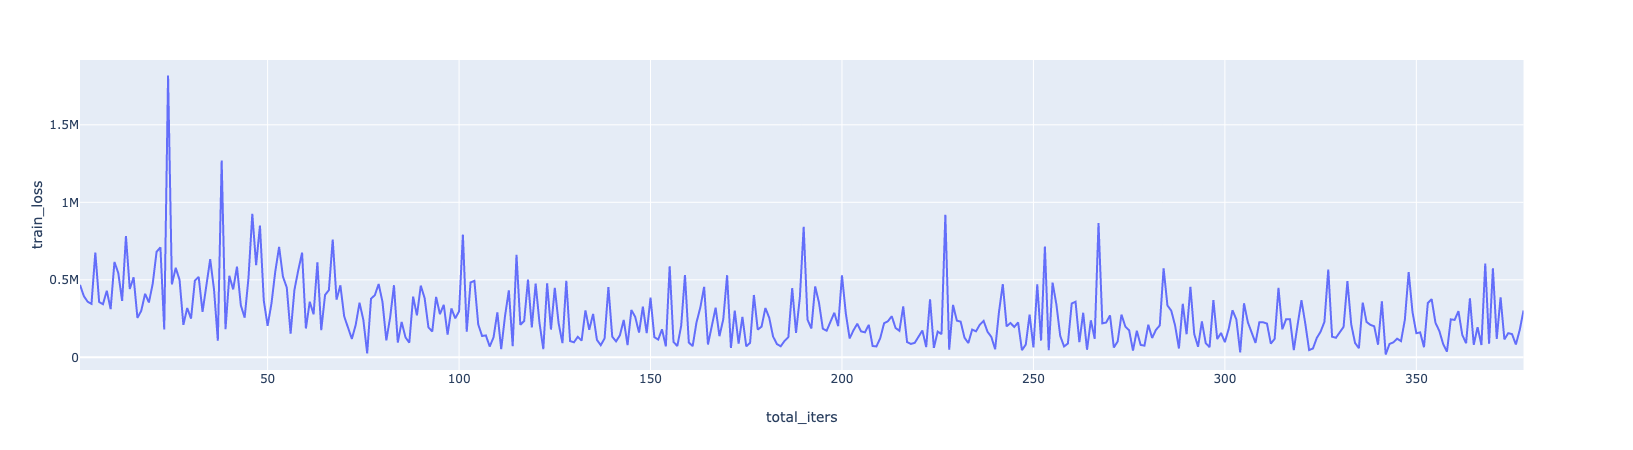

In [38]:
fig = px.line(trainer.step_info, x='total_iters', y='train_loss')
fig.show()


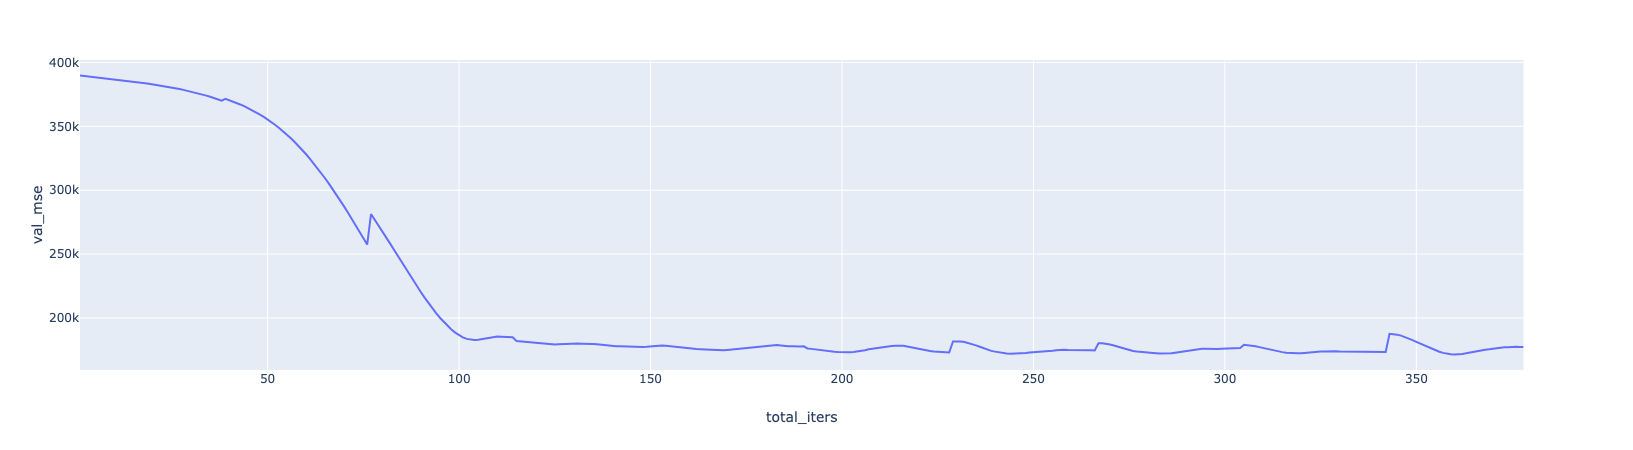

In [39]:
fig = px.line(trainer.step_info, x='total_iters', y='val_mse')
fig.show()


In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

(0, 3000)

(0, 3000)

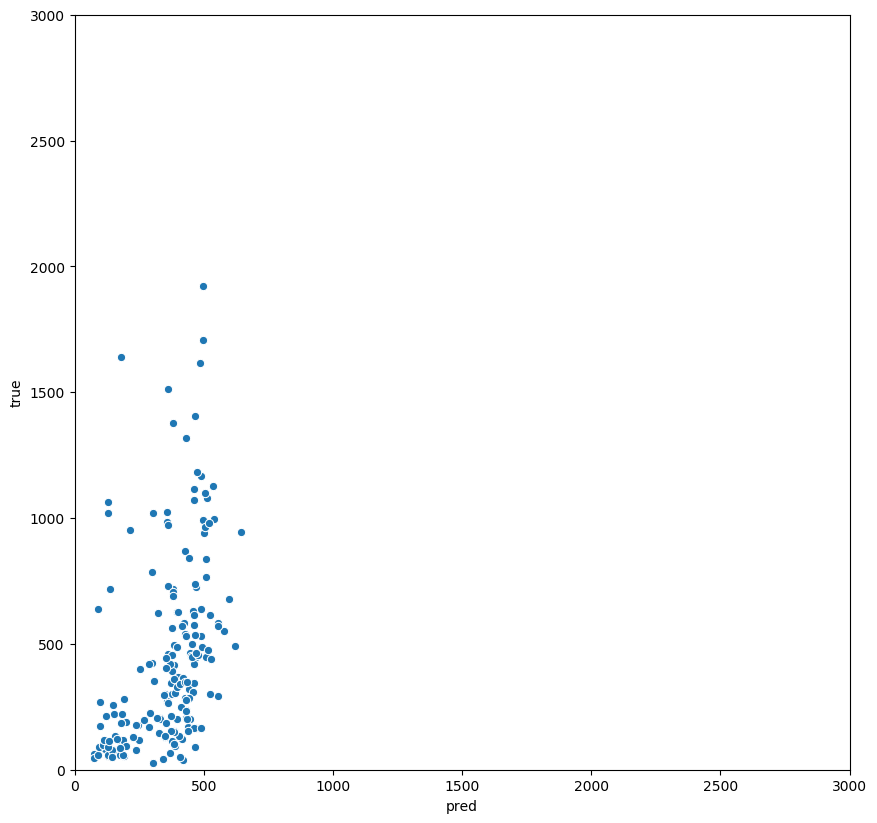

In [38]:
y_pred = trainer.predict(x_val)

_, ax = plt.subplots(figsize=(10, 10), dpi=100)

ax = sns.scatterplot(data=pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true', ax=ax)
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)

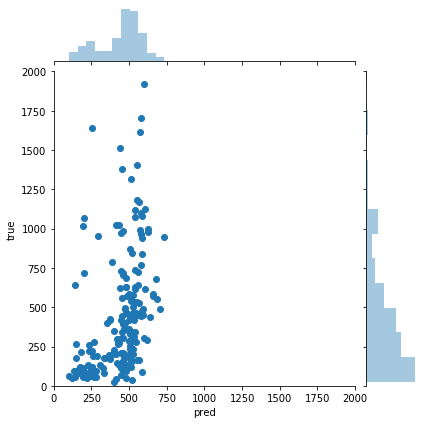

In [42]:
y_pred = trainer.predict(x_val, check_point='mse')

# _, ax = plt.subplots(figsize=(10, 10), dpi=100)

ax = sns.jointplot(data=pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true', xlim=(0, 2000), ylim=(0, 2000))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)

(0, 3000)

(0, 3000)

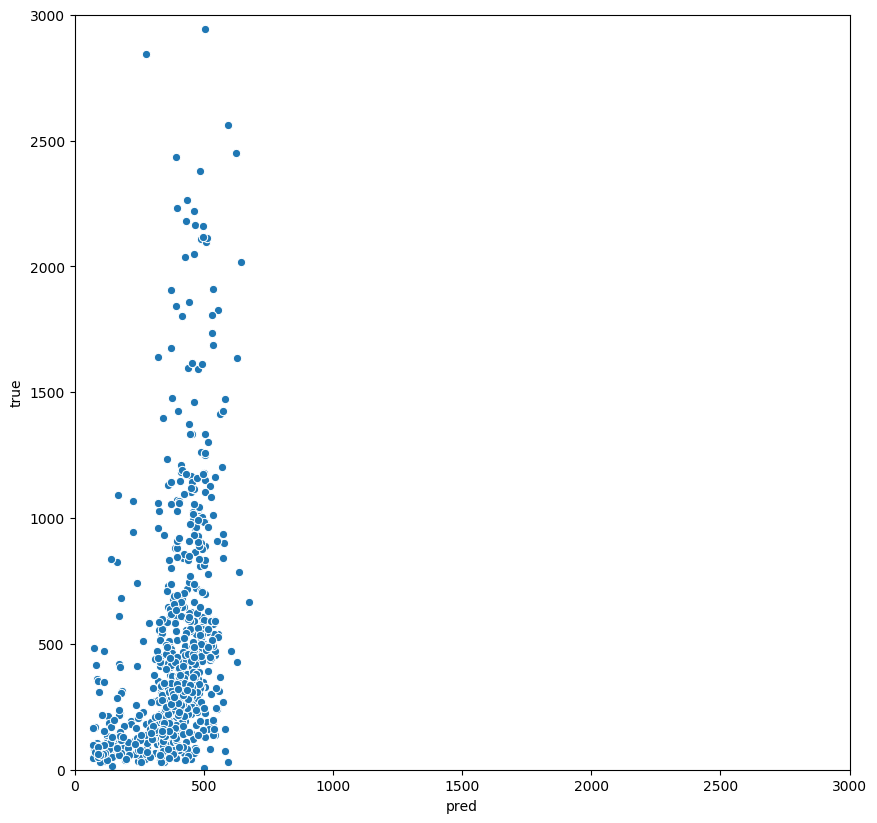

In [44]:
x_val, y_val = CrystalGraphDataset.collate_fn(x_train), y_train

y_pred = trainer.predict(x_val)

_, ax = plt.subplots(figsize=(10, 10), dpi=100)

ax = sns.scatterplot(data=pd.DataFrame({'pred': y_pred.flatten(), 'true': y_val.flatten()}), x='pred', y='true', ax=ax)
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)